# Mask R-CNN (Evaluate Fish Model)
Evaluate and visualise results model results.

## 1.1. libs

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask R-CNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

# Import fish.py (Mask R-CNN model API)
import fish

C:\Users\Chris\anaconda3\envs\maskrcnn-3\lib\site-packages\tensorflow\python\framework\dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Chris\anaconda3\envs\maskrcnn-3\lib\site-packages\tensorflow\python\framework\dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Chris\anaconda3\envs\maskrcnn-3\lib\site-packages\tensorflow\python\framework\dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Chris\anaconda3\envs\maskrcnn-3\lib\site-packages


lib: centroidtracker.py --- v1.0.002  ---



## 1.2. config

In [2]:
# Inference Configuration
config = fish.FishInferenceConfig()
# config.display()

# Dataset directory
DATASET_DIR = "C:/Users/Chris/Desktop/offline/maskrcnn-3/Mask_RCNN/datasets/fish/fish2A" # CHANGE TO YOUR FOLDER !!!

# Path to a specific weights file
WEIGHTS_PATH = "../../_weights/mask_rcnn_fish_0047.h5" # CHANGE TO YOUR WEIGHTS FILE !!!

# Directory to save logs and trained model
LOGS_DIR = "E:/logs" # LOGS_DIR = os.path.join(ROOT_DIR, "logs") # CHANGE TO YOUR LOG PATH !!!

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0
TEST_MODE = "inference"

## 1.3. matplotlib

In [3]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

## 2.1. Load Dataset

In [4]:
# Load validation/test dataset
dataset = fish.FishDataset()
dataset.load_fish(DATASET_DIR, "test")
dataset.prepare()

# print dataset details
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 201
Classes: ['BG', 'chrysoblephus_laticeps']


## 2.2. Load Model (& Weights)

In [5]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=LOGS_DIR, config=config)

# Load model weights
print("Loading weights ", WEIGHTS_PATH)
model.load_weights(WEIGHTS_PATH, by_name=True)

Loading weights  ../../_weights/mask_rcnn_fish_0047.h5


## A. mAP

In [6]:
def compute_batch_ap(dataset, image_ids, threshold, verbose=0):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        if threshold == "avg":
            ap = utils.compute_ap_range(
                gt_bbox, gt_class_id, gt_mask,
                r['rois'], r['class_ids'], r['scores'], r['masks'],
                verbose=0)
        else:
            ap = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
               r['rois'], r['class_ids'], r['scores'], r['masks'],
               iou_threshold=threshold)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap[0]))
        
        if type(ap) == tuple:
            APs.append(ap[0])
        else:
            APs.append(ap)
    return APs

In [7]:
# get mAP
AP50s = compute_batch_ap(dataset, dataset.image_ids[::], threshold=0.5)
print("mAP50 over {} images: {:.4f}".format(len(AP50s), np.mean(AP50s)))

AP70s = compute_batch_ap(dataset, dataset.image_ids[::], threshold=0.7)
print("mAP70 over {} images: {:.4f}".format(len(AP70s), np.mean(AP70s)))

APs = compute_batch_ap(dataset, dataset.image_ids[::], threshold="avg")
print("mAP50_95 over {} images: {:.4f}".format(len(APs), np.mean(APs)))

mAP50 over 201 images: 0.8145
mAP70 over 201 images: 0.8028
mAP50_95 over 201 images: 0.6383


## B. Run Detection

In [11]:
def visualise_detection(img_index):
    image_id = dataset.image_ids[img_index]
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    info = dataset.image_info[image_id]
    print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                           dataset.image_reference(image_id)))
    print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

    # Run object detection
    results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

    # Display results
    r = results[0]
    log("gt_class_id", gt_class_id)
    log("gt_bbox", gt_bbox)
    log("gt_mask", gt_mask)

    # Compute AP over range 0.5 to 0.95 and print it
    utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                           r['rois'], r['class_ids'], r['scores'], r['masks'],
                           verbose=1)

    visualize.display_differences(
        image,
        gt_bbox, gt_class_id, gt_mask,
        r['rois'], r['class_ids'], r['scores'], r['masks'],
        dataset.class_names,
        ax=get_ax(),
        show_box=True, show_mask=False,
        iou_threshold=0.5, score_threshold=0.5)


image ID: fish.BettysSite59Clip1_29988.jpg (184) C:/Users/Chris/Desktop/offline/maskrcnn-3/Mask_RCNN/datasets/fish/fish2A\test\BettysSite59Clip1_29988.jpg
Original image shape:  [1080 1920    3]
Processing 1 images
image                    shape: (576, 576, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 576, 576, 3)      min:    0.00000  max:  255.00000  uint8
image_metas              shape: (1, 14)               min:    0.00000  max: 1920.00000  float64
anchors                  shape: (1, 82863, 4)         min:   -0.62963  max:    1.51833  float32
gt_class_id              shape: (2,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (2, 4)                min:   29.00000  max:  377.00000  int32
gt_mask                  shape: (576, 576, 2)         min:    0.00000  max:    1.00000  bool
AP @0.50:	 0.500
AP @0.55:	 0.500
AP @0.60:	 0.500
AP @0.65:	 0.500
AP @0.70:	 0.500
AP @0.75:	 0.500
AP @0.80:	 0.500
AP @0

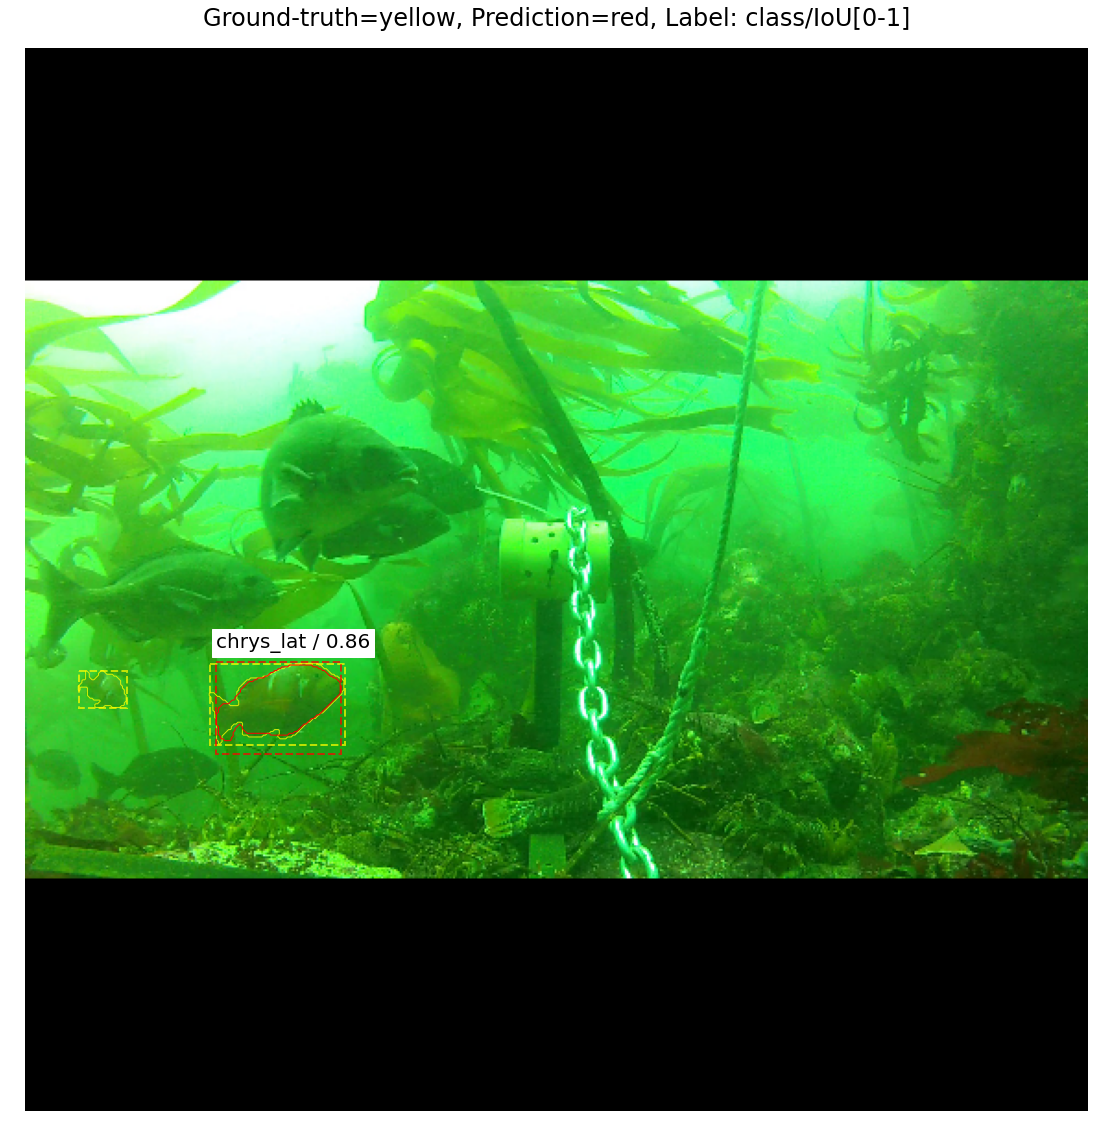

In [121]:
visualise_detection(1)